# Stable Diffusion

This notebook covers the usage of Stable Diffusion to create and modify images using existing pipelines. Some of the key ideas explored within this notebook are as follows:
- Generating images from text using the `StableDiffusionPipeline` and experimenting with the available arguments
- Exploring some of the key pipeline components in action
    - The VAE that makes this a 'latent diffusion model'
    - The tokenizer and text encoder that process the text prompt
    - The UNet itself
    - The scheduler, and exploring different schedulers
- Replicating the sampling loop with the pipeline components
- Editing existing images with the Img2Img pipeline
- Using inpainting and Depth2Img pipelines


# Setup

In [1]:
%pip install -Uq diffusers ftfy accelerate

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Installing transformers from source for now since we need the latest version for Depth2Img
%pip install -Uq git+https://github.com/huggingface/transformers 

Note: you may need to restart the kernel to use updated packages.


In [3]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt

# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline, 
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline, 
    StableDiffusionDepth2ImgPipeline
    )       

# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# Generating Images from Text

In [5]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

model_index.json:   0%|          | 0.00/543 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/807 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/911 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/553 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]


Once the stable diffusion pipeline is loaded, we generate an image based on a prompt with the following code:

  0%|          | 0/35 [00:00<?, ?it/s]

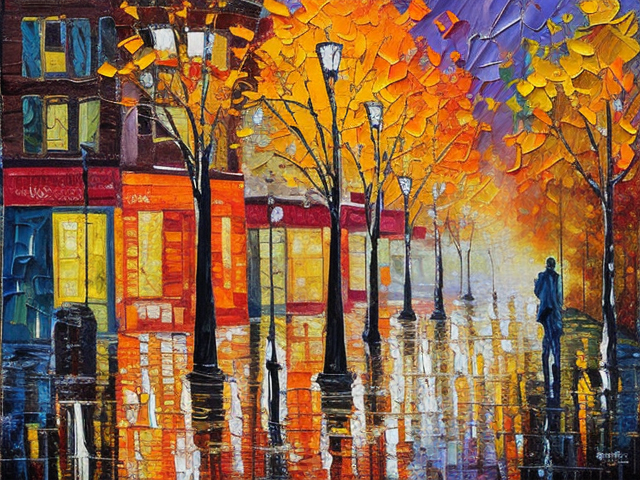

In [6]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape", # What to generate
    negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
    height=480, width=640,     # Specify the image size
    guidance_scale=8,          # How strongly to follow the prompt
    num_inference_steps=35,    # How many steps to take
    generator=generator        # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

The settings and prompt above can be tweaked to see how it affects the output of the pipeline

Some of the Key arguments to tweak:
- Width and height specify the size of the generated image. They must be divisible by **8** for the VAE to work 
- The number of steps influences the generation quality. The default (50) works well.
- The negative prompt is used during the classifier-free guidance process, and can be a useful way to add additional control. 
- The `guidance_scale` argument determines how strong the classifier-free guidance (CFG) is. Higher scales push the generated images to better match the prompt, but if the scale is too high the results can become over-saturated and unpleasant. 



The effect of increasing the guidance scale can be seen in the following cell:

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

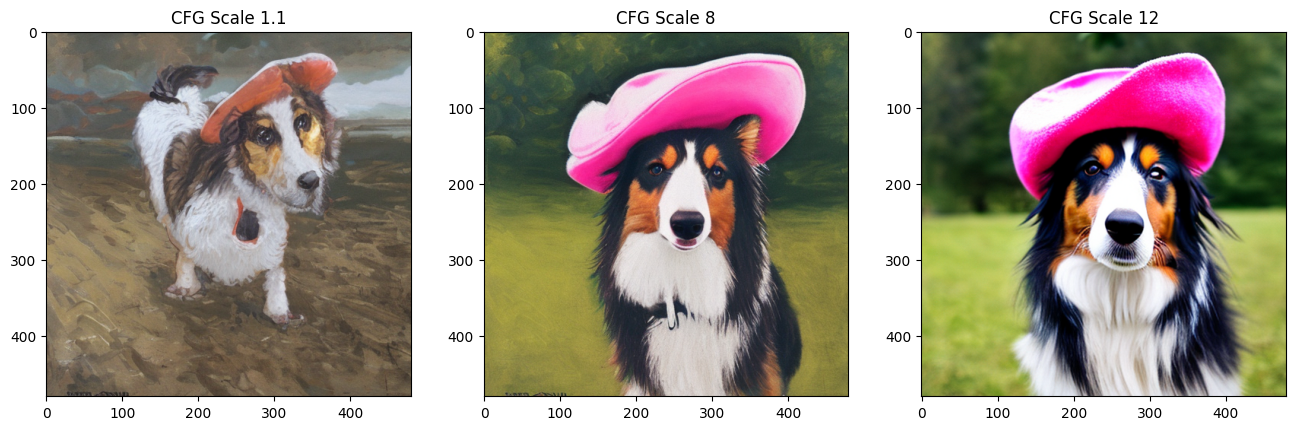

In [7]:
#@markdown comparing guidance scales:
cfg_scales = [1.1, 8, 12] #@param
prompt = "A collie with a pink hat" #@param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
  im = pipe(prompt, height=480, width=480,
    guidance_scale=cfg_scales[i], num_inference_steps=35,
    generator=torch.Generator(device=device).manual_seed(42)).images[0]
  ax.imshow(im); ax.set_title(f'CFG Scale {cfg_scales[i]}');

# Pipeline Components

In [8]:
print(list(pipe.components.keys())) # List components

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


### The VAE

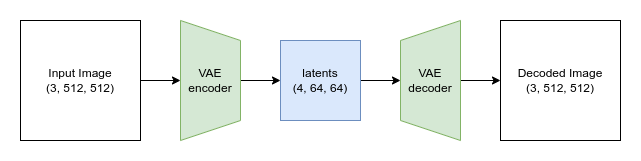

The VAE (Variational Autoencoder) is a model type capable of encoding its input into a condensed representation, subsequently decoding this `latent` representation to produce an output closely resembling the original input. In the context of generating images with Stable Diffusion, the process begins by generating the latents through the application of the diffusion process within the VAE's `latent space`. These latents are then decoded at the end to observe the resulting image.

The following code takes an input image, encodes it to a latent representation and then decodes it again using the VAE:

In [9]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1 
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
  latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
  decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


The 512x512 image is compressed to a 64x64 latent representation (with four channels). This 8x reduction in each spatial dimension is the reason the specified width and height need to be multiples of 8.

Working with these information-rich 4x64x64 latents is more efficient than working with massive 512px images, allowing for faster diffusion models that take less resources to train and use.

### The Tokenizer and Text Encoder


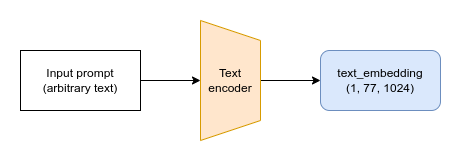


The objective of the text encoder is to convert an input string (the prompt) into a numerical representation suitable for conditioning the UNet. Initially, the text undergoes tokenization using the pipeline's tokenizer, resulting in a series of tokens. With a vocabulary of approximately 50k tokens, any words not in this vocabulary are subdivided into smaller sub-words. Subsequently, the tokens are processed through the text encoder model itself, which is a transformer model initially trained as the text encoder for CLIP. The expectation is that this pre-trained transformer model has acquired valuable representations of text, which can prove beneficial for the diffusion task as well.


In [10]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])['input_ids']
print("Input ID -> decoded token")
for input_id in input_ids[0]:
  print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
  text_embeddings = pipe.text_encoder(input_ids)['last_hidden_state']
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [11]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe.encode_prompt("A painting of a flooble", device, 1, False, '')
text_embeddings[0].shape

torch.Size([1, 77, 1024])

These text embeddings (the so-called 'hidden states' of the last transformer block in the text encoder model) will be fed to the UNet as an additional argument to the `forward` method.

### The UNet

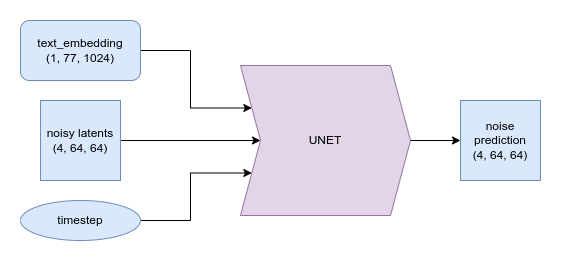

The UNet takes a noisy input and predicts the noise. The input is not an image but is instead a latent representation of an image. And in addition to the timestep conditioning, this UNet also takes in the text embeddings of the prompt as an additional input. Here it is making predictions on some dummy data:

In [12]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
  unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print('UNet output shape:', unet_output.shape) # Same shape as the input latents

UNet output shape: torch.Size([1, 4, 64, 64])


### The Scheduler

We can plot the noise schedule to see the noise level (based on $\bar{\alpha}$) over time:

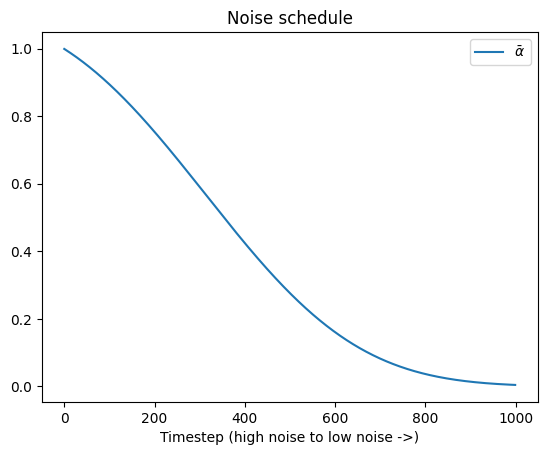

In [13]:
plt.plot(pipe.scheduler.alphas_cumprod, label=r'$\bar{\alpha}$')
plt.xlabel('Timestep (high noise to low noise ->)');
plt.title('Noise schedule');plt.legend();

Using another scheduler:

Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.24.0",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



  0%|          | 0/50 [00:00<?, ?it/s]

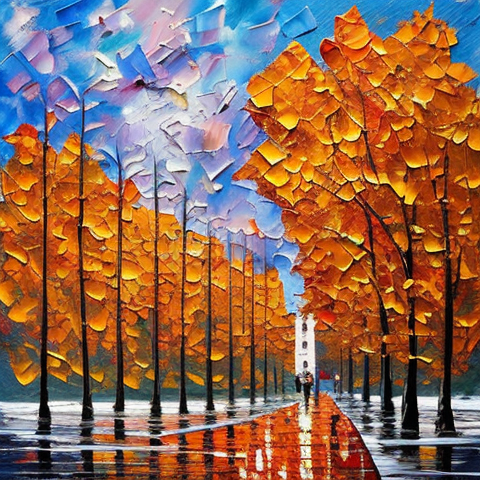

In [14]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print('Scheduler config:', pipe.scheduler)

# Generate an image with this new scheduler
pipe(prompt="Palette knife painting of an autumn cityscape", # What to generate
     negative_prompt="Oversaturated, blurry, low quality", # What NOT to generate
     height=480, width=480,
     generator=torch.Generator(device=device).manual_seed(42)).images[0]

### Sampling Loop


/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:292: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/opt/conda/lib/python3.10/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:521: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


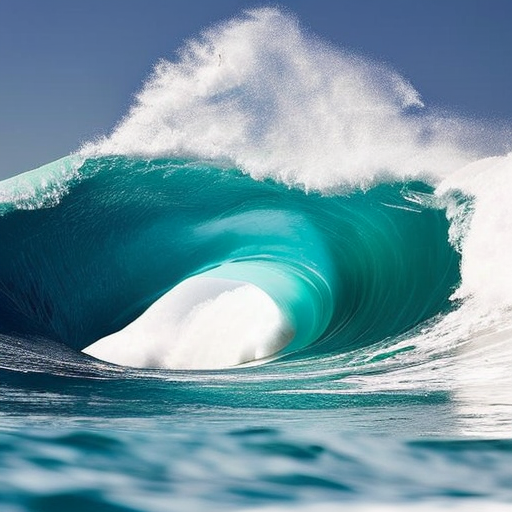

In [15]:
guidance_scale = 8 #@param
num_inference_steps = 30 #@param
prompt = "Beautiful picture of a wave breaking" #@param
negative_prompt = "zoomed in, blurry, oversaturated, warped" #@param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in enumerate(pipe.scheduler.timesteps):

  # Expand the latents if we are doing classifier free guidance
  latent_model_input = torch.cat([latents] * 2)

  # Apply any scaling required by the scheduler
  latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

  # Predict the noise residual with the UNet
  with torch.no_grad():
    noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # Perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # Compute the previous noisy sample x_t -> x_t-1
  latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
  image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]

# Additonal Pipelines

In this section we explore more pipelines to understand some of the other tasks that Stable Diffusion can be used for.

## Img2Img

In the previous instances, we created images entirely from random latents through the complete diffusion sampling loop. However, starting from scratch is not the only option. In the Img2Img pipeline, an existing image is initially encoded into a set of latents. Subsequently, some noise is introduced to these latents, serving as the starting point. The extent of noise added and the number of denoising steps applied determine the 'strength' of the img2img process. Adding a minimal amount of noise (low strength) leads to minimal alterations, while incorporating the maximum noise and executing the full denoising process results in an image that bears little resemblance to the input, aside from certain similarities in overall structure.

In [16]:
# Loading an Img2Img pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
img2img_pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

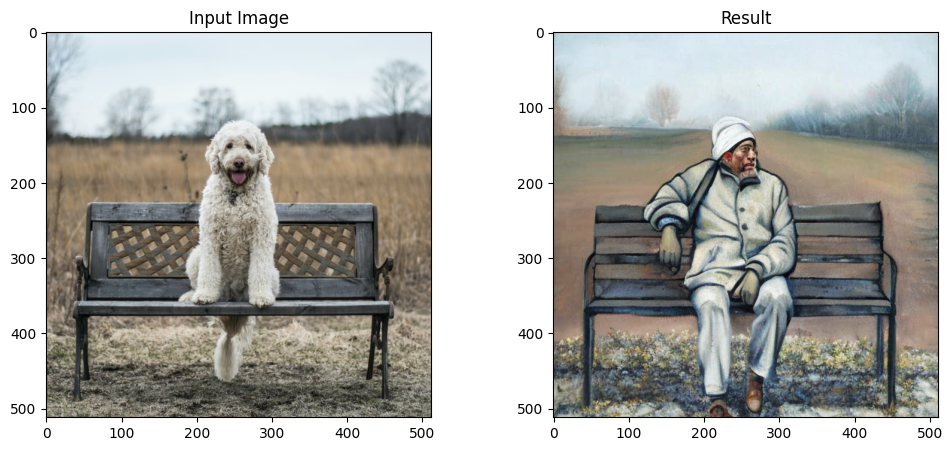

In [17]:
# Apply Img2Img
result_image = img2img_pipe(
    prompt="An oil painting of a man on a bench",
    image=init_image, # The starting image
    strength=0.6, # 0 for no change, 1.0 for max strength
).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(result_image);axs[1].set_title('Result');

## In-Painting

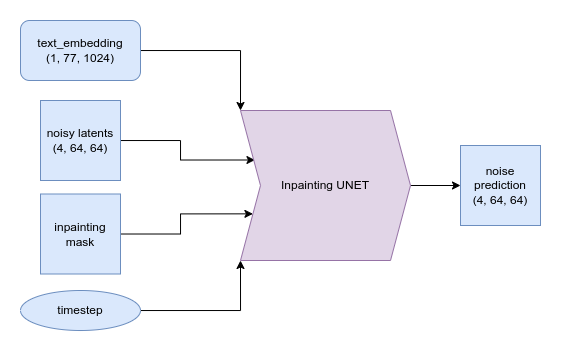


Consider the scenario where we wish to retain certain portions of the input image unchanged while generating new content in other regions. This process is known as 'inpainting.' Although achievable with the same model used in the previous demonstrations (via the StableDiffusionInpaintPipelineLegacy), superior results can be obtained by utilizing a custom fine-tuned version of Stable Diffusion that incorporates a mask as additional conditioning. The mask image should share the same shape as the input image, with white representing the areas to be replaced and black indicating the regions to remain unchanged. Below is the procedure for loading such a pipeline and applying it to the example image and mask loaded in the 'Setup' section:

In [18]:
# Set device
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda:1"
    if torch.cuda.is_available()
    else "cpu"
)

In [19]:
# Load the inpainting pipeline (requires a suitable inpainting model)
pipe = StableDiffusionInpaintPipeline.from_pretrained("runwayml/stable-diffusion-inpainting")
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

safety_checker/model.safetensors not found


Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/748 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.78k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

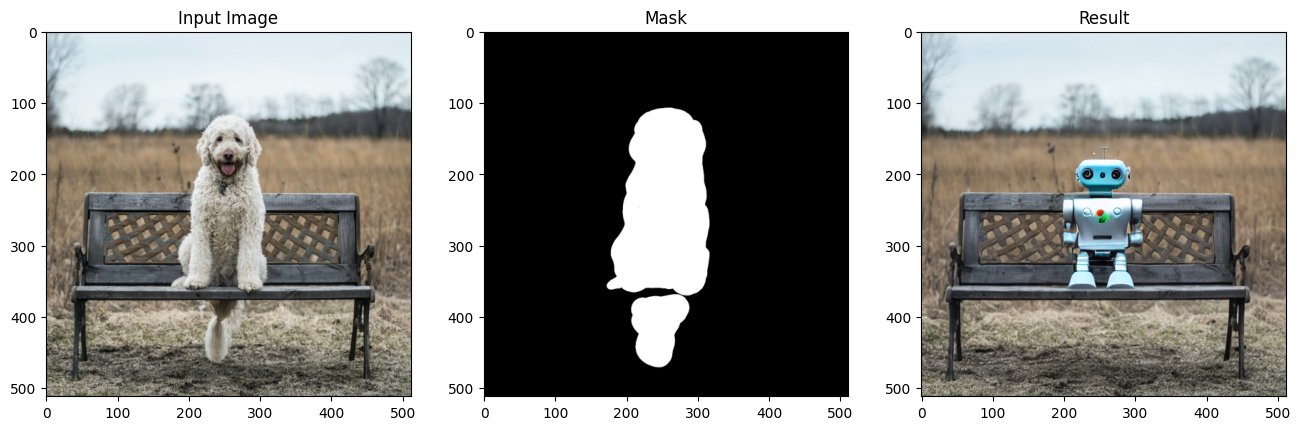

In [20]:
# Inpaint with a prompt for what we want the result to look like
prompt = "A small robot, high resolution, sitting on a park bench"
image = pipe(prompt=prompt, image=init_image, mask_image=mask_image).images[0]

# View the result
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(mask_image);axs[1].set_title('Mask')
axs[2].imshow(image);axs[2].set_title('Result');

In [21]:
!ls ~/.cache/huggingface/hub/ # List the contents of the cache directory

models--runwayml--stable-diffusion-inpainting	version.txt
models--stabilityai--stable-diffusion-2-1-base	version_diffusers_cache.txt


## Depth2Image


![depth to image examples](https://camo.githubusercontent.com/5a7cd804dff6283157144f1d54b99a637195fcd25f10c7e9ab7952322d746269/68747470733a2f2f68756767696e67666163652e636f2f73746162696c69747961692f737461626c652d646966667573696f6e2d322d64657074682f7265736f6c76652f6d61696e2f646570746832696d6167652e706e67)
_Input image, depth image and generated examples (image source: StabilityAI)_

Depth2Image is used to create a new image with the composition of the original but completely different colours or textures. It can be difficult to find an Img2Img strength that preserves what we'd like of the layout without also keeping the input colors. 

It takes in depth information as additional conditioning when generating. The pipeline uses a depth estimation model to create a depth map, which is then fed to the fine-tuned UNet when generating images to (hopefully) preserve the depth and structure of the initial image while filling in completely new content.

In [22]:
# Load the Depth2Img pipeline (requires a suitable model)
pipe = StableDiffusionDepth2ImgPipeline.from_pretrained("stabilityai/stable-diffusion-2-depth")
pipe = pipe.to(device)

model_index.json:   0%|          | 0.00/545 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/382 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/346 [00:00<?, ?B/s]

depth_estimator/config.json:   0%|          | 0.00/9.96k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/732 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.07k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/923 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/490M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

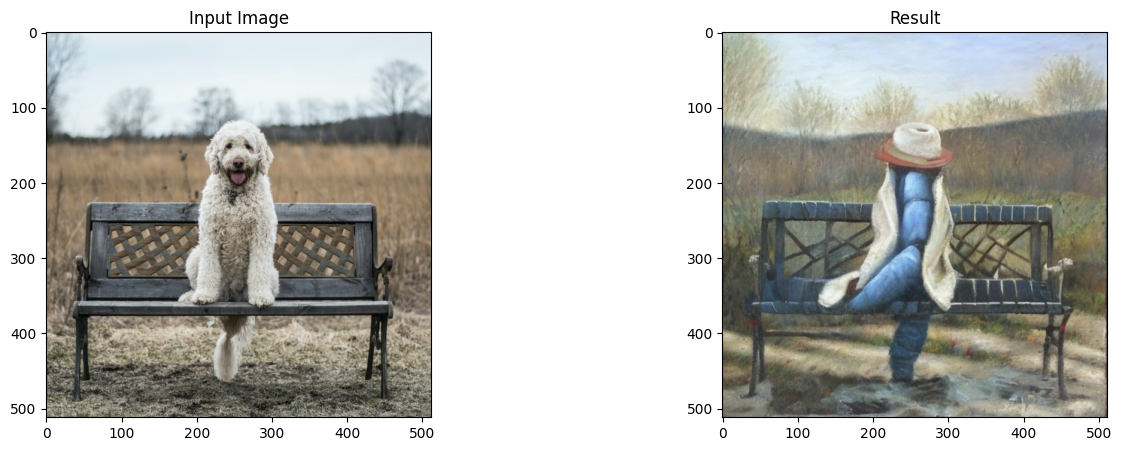

In [23]:
# Inpaint with a prompt for what we want the result to look like
prompt = "An oil painting of a man on a bench"
image = pipe(prompt=prompt, image=init_image).images[0]

# View the result
fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs[0].imshow(init_image);axs[0].set_title('Input Image')
axs[1].imshow(image);axs[1].set_title('Result');